### **4 Feature engineering of the target variable and model testing**
Our next step in the process of building a model to predict if an item is going to be returned or not, will include feature engineering of the categorical variables and building the base models.
Our dataset contains numerous categorical variables, which depending on the model we use, must be encoded in a specific way in order for the model to be able to interpret them. Furthermore, some of the categorical variables such as **item_id**, **user_id**, **brand_id** possess a large number of unique values or in other words said these variables have high **cardinality**. In order to make use of them we will use a technique called **"target encoding"**, which in its essence is a technique to reduce the cardinality of the categorical variables by replacing all unique values of a variable with its **target mean**.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette = "Dark2")
my_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
  (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)]
pd.set_option('display.max_columns', None)
from itertools import chain, combinations

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import tensorflow as tensorflow
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

#### **4.1 One hot encoding**

In [6]:
df = pd.read_csv("df_processed.csv")
df

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,0.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808,52,89,0,4,4,4,2,6,14,14,39.90,1,39.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,S-Holstein,2011-02-16,0.0,4,2012-04-02_825,48,411,0,4,4,4,2,6,14,14,83.23,3,249.7,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,83.13,9,748.2,0,9,4,5,2,7,3,6,0,9,0,9,2,7,3,6,2,7,0,9,2,7
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,83.13,9,748.2,1,8,4,5,2,7,3,6,1,8,1,8,2,7,3,6,2,7,1,8,2,7
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095,63,35,6,3,4,5,28,2,17,18,79.90,1,79.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Bburg,2013-04-28,NaN,4,2013-04-28_91922,43,0,6,3,4,5,28,2,17,18,59.90,2,119.8,1,1,1,1,0,2,1,1,1,1,0,2,0,2,1,1,0,2,0,2,0,2


In [7]:
low_cardinality_cat_cols = ["size","item_color","user_title","user_state"]
high_cardinality_cat_cols = ["item_id","brand_id","user_id"]
cat_cols = low_cardinality_cat_cols + high_cardinality_cat_cols
# size of the known dataset
k = max(df["order_item_id"])-1

In [14]:
# Drop unnecessary columns
columns_to_drop = ["order_date", "delivery_date", "user_dob", "user_reg_date", "order_id","order_item_id"]
df.drop(columns_to_drop, axis=1, inplace=True)
# Get the validation set
df_valid = df.iloc[k:, :]

In order for some of our models to be able to interpret the categorical variables, we will use **"one_hot_encoding"** to encode the categorical variables. This is a technique that involves replacing each **unique value** of a variable with a binary vector of size equal to the number of **unique values** of the variable. For example, if a variable has 3 unique values, then the binary vector will be of size 3. If the value of the variable is 1, then the first element of the vector will be 1 and the others will be 0. If the value of the variable is 2, then the second element of the vector will be 1 and the others will be 0.

In [17]:
# Use one hot encoding to encode the categorical variables including only variables with frequency more than 50
def one_hot_encoding(df):
    transformer =   make_column_transformer(
                    (OneHotEncoder(min_frequency=50,drop= "first"), ['size', 'item_color',"user_title","user_state"]),
                    remainder='passthrough')
    transformed_fitted = transformer.fit_transform(df)
    transformed_df = pd.DataFrame(transformed_fitted, columns=transformer.get_feature_names())
    return transformed_df

#### **4.2 Defining the models**

As base models, we are going to use **LightGBM**, **XGBoost**, **CatBoost** and **Neural Network**. **LightGBM** and **CatBoost**** can handle categorical variables as long as they are of type "category" **Xgboost** and **Neural Networks** do not support them natively, thus we need to one-hot encode them.

We are going to divide our dataset into two sets: **train** with months 11 months spanning from April to February and **test** containing the transactions in March. We will use the **train** set to build our model and the **test** set to evaluate its performance. It is important to split the data "manually" and not use a randomized train test split because we want to avoid target leakage and prevent overfitting of the model since every single item is a part of specific order and many customers are one-time buyers. If we split the data randomly, we will mix the items in the train and test sets in a way that violates our assumptions, and end up with a model that is not able to generalize to new data. For example, if an item in the test set was bought from a one-time buyer, that has returned all his items, then the model will be able to predict that he will also most likely return the item as well.

In [8]:
# Xgboost classifier to train the model and use ROC as the metric
def xgboost_classifier(df, cat_cols):
    if cat_cols:
        df_cat = one_hot_encoding(df)
    else:
        df_cat = df
    df_train,df_test = df_cat.loc[:k][df_cat.loc[:k,"order_month"] != 3],df_cat.loc[:k][df_cat.loc[:k,"order_month"] == 3]
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    
    model = XGBClassifier(max_depth=7, n_estimators=50, learning_rate=0.1,
                            n_jobs=-1, random_state=42)
    model.fit(X_train, Y_train, eval_metric='auc', eval_set=[(X_test, Y_test)],early_stopping_rounds = 20,verbose = 0)
    Y_pred = model.predict(X_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("Xgboost AUC on test set:", auc)
    return model,auc

In [9]:
# Catboost classifier to train the model and use ROC as the metric
def catboost_classifier(df,cat_cols):
    df_train,df_test = df.loc[:k][df.loc[:k,"order_month"] != 3],df.loc[:k][df.loc[:k,"order_month"] == 3]
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    model = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=10,
                            loss_function='Logloss', eval_metric='AUC',
                            random_seed=42)
    pool_train = Pool(X_train, Y_train,cat_features = cat_cols)

    pool_test = Pool(X_test, Y_test,cat_features = cat_cols)
    

    
    model.fit(pool_train, eval_set=pool_test, use_best_model=True, verbose=False)
    Y_pred = model.predict(pool_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("Catboost AUC on test set:", auc)
    return model,auc

In [10]:
# LightGBM
def lightgbm(df,cat_cols):
    df_cat_int = df.copy()
    for i in cat_cols:
        df_cat_int[i] = df_cat_int[i].astype('category')
    
    df_train,df_test = df_cat_int.loc[:k][df_cat_int.loc[:k,"order_month"] != 3],df_cat_int.loc[:k][df_cat_int.loc[:k,"order_month"] == 3]
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    
    model = LGBMClassifier(boosting_type='gbdt')
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("LGBM AUC on test set: ", auc)
    return model,auc

In [27]:
# Neural network to train the model and use ROC as the metric
def neural_network(df,epochs,cat_cols):
    if cat_cols:
        df_cat = one_hot_encoding(df)
    else:
        df_cat = df
    df_train,df_test = df_cat.loc[:k][df_cat.loc[:k,"order_month"] != 3],df_cat.loc[:k][df_cat.loc[:k,"order_month"] == 3]
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    auc = tensorflow.keras.metrics.AUC()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    
    results = model.fit(X_train, Y_train, epochs=epochs, batch_size=256, verbose=1,validation_data=(X_test, Y_test))
    Y_pred = model.predict(X_test)
    auc_1 = roc_auc_score(Y_test, Y_pred)
    print("ROC on test set:", auc_1)
     
    return model,auc_1, results.history[auc.name], results.history['val_'+auc.name]


In [12]:
# Get feature importance from the tree-based models
def get_feature_importance(model,df):
    return list(sorted(zip(df.columns.drop("return"), model.feature_importances_), key=lambda xx: xx[1], reverse=True))

#### **4.3 Fitting the models**
In this subsection we will fit the models and evaluate their performance using the Area Under the Receiver Operating Characteristic (AUROC) or also known as Area Under the Curve (AUC) as a metric. The plot of the receiver operating characteristic (ROC) curve is a graphical method of visualizing the performance of a binary classifier model. The ROC curve is a plot of the true positive rate against the false positive rate. The AUC is the area under the ROC curve and it can take values between 0 and 1. A model with an AUC of 1 is a perfect model and a model with an AUC of 0 is a model that never makes correct prediction.  


<p align="center">
  <img src="Roc_curve.png"  width=700 />
</p>

In [15]:
catboost_model,catboost_auc = catboost_classifier(df.iloc[:k, :],cat_cols)

Catboost AUC on test set: 0.6678116658929746


In [18]:
xgb_model,xgb_auc = xgboost_classifier(df.iloc[:k, :],cat_cols)

Xgboost AUC on test set: 0.6495022561808238


In [19]:
lightgbm_model,lightgbm_auc = lightgbm(df,cat_cols)

LGBM AUC on test set:  0.666506669963591


In [28]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df,20,cat_cols)

Epoch 1/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6556 - auc_4: 0.6533 - val_loss: 0.6586 - val_auc_4: 0.6577
Epoch 2/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6391 - auc_4: 0.6800 - val_loss: 0.6502 - val_auc_4: 0.6694
Epoch 3/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6313 - auc_4: 0.6914 - val_loss: 0.6480 - val_auc_4: 0.6730
Epoch 4/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6277 - auc_4: 0.6969 - val_loss: 0.6501 - val_auc_4: 0.6722
Epoch 5/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6253 - auc_4: 0.7000 - val_loss: 0.6513 - val_auc_4: 0.6755
Epoch 6/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6232 - auc_4: 0.7031 - val_loss: 0.6509 - val_auc_4: 0.6746
Epoch 7/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6214 - auc_4: 0.7055 - val_loss: 0.6551 - val_auc_4: 0.6752
Epoch 8/20
1608/1608 [============

At this stage we will not tune any hyperparameters, we will just use the default parameters of the models, except for the **Neural Network**. Reason for this is that judging from the above output we can see that although the AUC of the training set is increasing with each iteration, the AUC of the validation set reaches a plateau between 3 and 5 Epochs. This is an indicator that the model is overfitting and we need to tune the number of epochs to be in the aforementioned range.

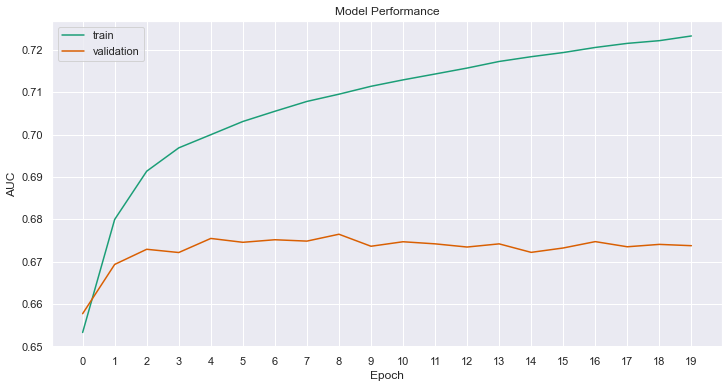

In [29]:
    plt.figure(figsize=(12,6))
    # plot results train and results test using sns
    sns.lineplot(x=range(len(results_train)), y=results_train, label='Train')
    sns.lineplot(x=range(len(results_test)), y=results_test, label='Test')
    plt.xticks(np.arange(0, len(results_test), step = 1))
    plt.title('Model Performance')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [30]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df,5,cat_cols)

Epoch 1/5
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6556 - auc_5: 0.6531 - val_loss: 0.6586 - val_auc_5: 0.6636
Epoch 2/5
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6373 - auc_5: 0.6826 - val_loss: 0.6516 - val_auc_5: 0.6709
Epoch 3/5
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6307 - auc_5: 0.6922 - val_loss: 0.6498 - val_auc_5: 0.6762
Epoch 4/5
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6276 - auc_5: 0.6969 - val_loss: 0.6556 - val_auc_5: 0.6750
Epoch 5/5
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6251 - auc_5: 0.7005 - val_loss: 0.6470 - val_auc_5: 0.6757
ROC on test set: 0.6757458034108117


In [31]:
auc_dict = {"Catboost":catboost_auc,"Xgboost":xgb_auc,"Lightgbm":lightgbm_auc,"Neural_Network":neural_network_auc}
model_results = pd.DataFrame(auc_dict,index=["AUC"])
model_results.sort_values(by="AUC",ascending=False,inplace=True,axis=1)

In [33]:
model_results.transpose()

,AUC
Neural_Network,0.675746
Catboost,0.667812
Lightgbm,0.666507
Xgboost,0.649502


From the preliminary fitting of the the models we can see that our models performance is modest. With neural network having the highest AUC, followed closely by Catboost and LightGBM. Xgboost has the lowest AUC and thus the lowest performance.

### **4.4 Target encoding**

By utilizing the one hot encoding technique, we were able to use our categorical variables in our models. One downside of this technique is the addition of a column for every unique value of the categorical variable. For example if a variable has 3 unique values, then the new columns will be named as color_1, color_2 and color_3. This leads to an increase in model complexity due to the added sparseness of the data. Furthermore one-hot encoding is not suitable in handling categorical variables with a large number of unique values as converting these values to binary vectors can be computationally expensive and it also exacerbate the problem of **sparse data**. Therefore we will use **"target encoding"** to encode the categorical variables. This is a technique that calculates the mean response of the target variable for every column and its unique values. The upside of this technique is that it is a simple technique to handle categorical variables and it does not add any new columns to the dataset as opposed to **one-hot encoding**. The downside is that it is prone to **target leakage** and **overfitting** and thus needs to be slightly altered to prevent these issues.

Here is an example how to use **"target encoding"** to encode the categorical variable **size**.

In [34]:
example_target_encoding = df[["size","return"]].groupby("size")["return"].mean().reset_index()
example_target_encoding

,size,return
0,l,0.484930
1,m,0.504160
2,s,0.498293
3,unsized,0.410574
4,xl,0.466682
5,xs,0.497458
6,xxl,0.537371
7,xxxl,0.352067


After encoding the categorical variables we will perform a **left join** on **size** between the original dataframe and the dataframe containing the encoded classes and we will drop the original columns as its no longer needed. 

First we will demonstrate what target leakage and overfitting is by calculating the mean response variable on the **whole** dataset.

In [35]:
def get_return_ratio(df, columns):
    df_known = df.iloc[:k]
    for i in columns:
        df_total = round(df_known[[i,"return"]].groupby(i).mean(),4)
        df_total.rename(columns = {'return':i + '_return_rate'},inplace = True)
        df_known = pd.merge(df_known, df_total, on = i, how = "left")
        df_known.drop(i, axis = 1, inplace = True)
    return df_known

In [36]:
df_return = get_return_ratio(df,cat_cols)
# Reorder the columns
def reorder_columns(df_return):
    temp_cols = df_return.columns.tolist()
    len_cat_cols = len(cat_cols)
    new_cols = temp_cols[-len_cat_cols:] + temp_cols[:-len_cat_cols]
    df_return = df_return[new_cols]
    return df_return

df_return = reorder_columns(df_return)

In [37]:
df_return

,size_return_rate,item_color_return_rate,user_title_return_rate,user_state_return_rate,item_id_return_rate,brand_id_return_rate,user_id_return_rate,item_price,return,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,0.4983,0.5707,0.4854,0.4819,0.6431,0.6297,0.4545,69.90,0.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3
1,0.4106,0.5170,0.4854,0.4819,0.6100,0.5727,0.4545,69.95,1.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
2,0.4106,0.5141,0.4854,0.4819,0.6100,0.5727,0.4545,69.95,1.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
3,0.4983,0.4500,0.4854,0.5079,0.4470,0.5219,0.0000,39.90,0.0,4,52,89,0,4,4,4,2,6,14,14,39.90,1,39.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,0.4983,0.5012,0.4854,0.4897,0.5882,0.6113,0.1111,29.90,0.0,4,48,411,0,4,4,4,2,6,14,14,83.23,3,249.7,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481086,0.4983,0.4956,0.4101,0.4850,0.6613,0.5186,0.7627,139.90,1.0,9,50,750,6,1,3,4,31,9,13,15,139.90,2,279.8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
481087,0.4983,0.4956,0.4101,0.4850,0.6613,0.5186,0.7627,139.90,1.0,9,50,750,6,1,3,4,31,9,13,15,139.90,2,279.8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
481088,0.4983,0.5085,0.4854,0.4692,0.6162,0.5509,0.0000,130.00,0.0,2,48,372,6,1,3,4,31,2,13,14,130.00,1,130.0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
481089,0.4667,0.5012,0.4101,0.4692,0.6364,0.4623,0.0000,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.7,0,3,2,1,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3


In [38]:
catboost_model,catboost_auc = catboost_classifier(df_return,[])

Catboost AUC on test set: 0.7680148246050316


We can see that incorporating the target encoding technique improved the performance of the model by a large margin. Nonetheless, we can assume with utmost certainty that this model wont be able to generalize to new data since the calculation of the target mean is done on the whole dataset, before a split has been made.

In [39]:
features = get_feature_importance(catboost_model,df_return)
features[:10]

[('user_id_return_rate', 68.09049162699301),
 ('delivery_time', 8.624914361058728),
 ('item_id_return_rate', 7.812798374410681),
 ('delivery_weekday', 4.615508212321823),
 ('order_number_same_item_id_item_color', 0.995535607721055),
 ('item_price', 0.9740848173143235),
 ('delivery_week', 0.7548947136119136),
 ('user_reg_age', 0.6964972476268051),
 ('order_number_different_size_item_color', 0.5662050857967179),
 ('order_number_different_size_item_color_brand_id', 0.46470363008984406)]

Judging by the feature importance **user_id_return_rate** is by far the most important feature followed by **item_id_return_rate** and both are most likely to be the cause of the target leakage.

In [95]:
df_return["user_id_return_rate"].value_counts()

0.0000    44242
0.5000    31228
1.0000    19384
0.6667    17637
0.3333    15912
          ...  
0.9259       27
0.9630       27
0.9200       25
0.9600       25
0.9545       22
Name: user_id_return_rate, Length: 948, dtype: int64

As we can see from the above output there are **44242** occurrences of items ordered by users who have never returned their items and **19384** who returned all their items. Thus the **user_id_return_rate** can be seen as a **proxy** for the target variable **return_rate** which in turn leads to the target leakage. To combat this we need to calculate the **mean** response** of the target variable for the training set and use the values for the test set since in real conditions it would be impossible to calculate the mean response of the target variable on new observations since we will not know the target values of these new observations.

In [40]:
# Define new way to calculate the return rate
def get_return_ratio(df, columns):
    # split the dataframe into train and test
    df_train,df_test = df.loc[:k][df.loc[:k,"order_month"] != 3],df.loc[:k][df.loc[:k,"order_month"] == 3]
    for i in columns:
        df_total = round(df_train[[i,"return"]].groupby(i).mean(),4)
        df_total.rename(columns = {'return':i + '_return_rate'},inplace = True)
        
        df_train = pd.merge(df_train, df_total, on = i, how = "left")
        df_test = pd.merge(df_test, df_total, on = i, how = "left")
        df_train.drop(i, axis = 1, inplace = True)
        df_test.drop(i, axis = 1, inplace = True)
    df_return = pd.concat([df_train,df_test])
    df_return.reset_index(drop=True,inplace=True)
    return df_return

In [41]:
df_return = get_return_ratio(df,cat_cols)
df_return = reorder_columns(df_return)
df_return

,size_return_rate,item_color_return_rate,user_title_return_rate,user_state_return_rate,item_id_return_rate,brand_id_return_rate,user_id_return_rate,item_price,return,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,0.4951,0.5647,0.4805,0.4775,0.6431,0.6302,0.4545,69.90,0.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3
1,0.4077,0.5132,0.4805,0.4775,0.6096,0.5727,0.4545,69.95,1.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
2,0.4077,0.5068,0.4805,0.4775,0.6096,0.5727,0.4545,69.95,1.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
3,0.4951,0.4409,0.4805,0.5027,0.4472,0.5071,0.0000,39.90,0.0,4,52,89,0,4,4,4,2,6,14,14,39.90,1,39.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,0.4951,0.4983,0.4805,0.4828,0.5714,0.6107,0.0000,29.90,0.0,4,48,411,0,4,4,4,2,6,14,14,83.23,3,249.7,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481087,0.4951,0.4883,0.4112,0.4818,0.6849,0.5142,0.7544,139.90,1.0,9,50,750,6,1,3,4,31,9,13,15,139.90,2,279.8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
481088,0.4951,0.5023,0.4805,0.4631,0.5957,0.5435,NaN,130.00,0.0,2,48,372,6,1,3,4,31,2,13,14,130.00,1,130.0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
481089,0.4631,0.4983,0.4112,0.4631,0.6034,0.4522,NaN,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.7,0,3,2,1,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
481090,0.4631,0.4983,0.4112,0.4631,0.7229,0.5800,NaN,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.7,0,3,2,1,1,2,1,2,0,3,0,3,1,2,1,2,0,3,0,3,0,3


One downside of this approach is that unique values of the test set cannot be encoded, since we do not know their target values and they will be marked as NaNs. In order to fix this issue we will be replacing all NaNs with 0.5.

In [42]:
df_return.isnull().sum()

size_return_rate                                       0
item_color_return_rate                                 0
user_title_return_rate                                 0
user_state_return_rate                                 0
item_id_return_rate                                  161
brand_id_return_rate                                   0
user_id_return_rate                                31007
item_price                                             0
return                                                 0
delivery_time                                          0
user_age                                               0
user_reg_age                                           0
order_weekday                                          0
delivery_weekday                                       0
order_month                                            0
delivery_month                                         0
order_day                                              0
delivery_day                   

In [43]:
# fill nan values with 0
df_return.fillna(0.5,inplace=True)

In [44]:
catboost_model,catboost_auc = catboost_classifier(df_return,[])

Catboost AUC on test set: 0.6524911697981635


Now our model scored much worse than before, and even slightly worse than before incorporating the target encoding technique.

In [45]:
features = get_feature_importance(catboost_model,df_return)
features[:10]

[('user_id_return_rate', 67.9803375862762),
 ('item_id_return_rate', 8.088332034070952),
 ('delivery_time', 7.698456911586742),
 ('delivery_weekday', 4.111901341653366),
 ('item_price', 1.2355343966991632),
 ('user_reg_age', 0.9511498737060675),
 ('order_number_same_item_id_item_color', 0.8877618462462491),
 ('order_number_different_size_item_color', 0.6828471853564345),
 ('order_week', 0.5399623221262234),
 ('order_number_different_item_color_brand_id', 0.4907162539231522)]

We can see that the **user_id_return_rate** is still the most important feature and while this time it no longer cause target leakage, it still causes overfitting and thus lower performance on the test set. In the next step in order to combat the overfitting we will divide our data into **three sets**. The **first set** is going to be used for calculating the mean response of the target variable, the **second set** is going to be used for fitting the model and the **third** set is going to be used for evaluating the model.

<p align="center">
  <img src="time_window.png" />
</p>

In [46]:
# Compute the target response statistics for the first 8 months of the dataset train on the next 3 months and test on 1 month
def get_return_ratio(df, columns):
    # split the data frame into train and test
    df_train = df.loc[:k][(df.loc[:k,"order_month"] > 3) & (df.loc[:k,"order_month"] < 12)]
    df_test  = df.loc[:k][(df.loc[:k,"order_month"] <= 3) | (df.loc[:k,"order_month"] == 12)]
    for i in columns:
        df_total = round(df_train[[i,"return"]].groupby(i).mean(),4)
        df_total.rename(columns = {'return':i + '_return_rate'},inplace = True)
        
        df_train = pd.merge(df_train, df_total, on = i, how = "left")
        df_test = pd.merge(df_test, df_total, on = i, how = "left")
        df_train.drop(i, axis = 1, inplace = True)
        df_test.drop(i, axis = 1, inplace = True)
    # df_return = pd.concat([df_train,df_test])
    df_return = df_test
    df_return.reset_index(drop=True,inplace=True)
    return df_return

In [47]:
df_return = get_return_ratio(df,cat_cols)
df_return = reorder_columns(df_return)


In [48]:
df_return

,size_return_rate,item_color_return_rate,user_title_return_rate,user_state_return_rate,item_id_return_rate,brand_id_return_rate,user_id_return_rate,item_price,return,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,0.4032,0.4921,0.4698,0.4542,0.5195,0.5819,0.6216,90.00,1.0,2,43,654,5,0,12,12,1,3,48,49,90.00,2,180.00,1,1,1,1,0,2,1,1,1,1,0,2,0,2,1,1,0,2,0,2,0,2
1,0.4032,0.4895,0.4698,0.4542,0.5195,0.5819,0.6216,90.00,0.0,4,43,654,5,2,12,12,1,5,48,49,90.00,2,180.00,1,1,1,1,0,2,1,1,1,1,0,2,0,2,1,1,0,2,0,2,0,2
2,0.4868,0.4921,0.4698,0.4660,0.4348,0.5164,NaN,160.00,0.0,2,44,654,5,0,12,12,1,3,48,49,160.00,1,160.00,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
3,0.4862,0.4253,0.4698,0.4627,0.5760,0.4902,0.6154,99.95,1.0,20,45,195,5,4,12,12,1,21,48,51,99.95,1,99.95,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,0.4868,0.4895,0.4698,0.4562,0.7873,0.5644,0.1364,79.90,0.0,2,48,194,5,0,12,12,1,3,48,49,79.90,1,79.90,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189325,0.4862,0.4829,0.4158,0.4757,NaN,0.4998,0.7955,139.90,1.0,9,50,750,6,1,3,4,31,9,13,15,139.90,2,279.80,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
189326,0.4862,0.4864,0.4698,0.4542,NaN,0.5164,NaN,130.00,0.0,2,48,372,6,1,3,4,31,2,13,14,130.00,1,130.00,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
189327,0.4513,0.4895,0.4158,0.4542,NaN,0.4357,NaN,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.70,0,3,2,1,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
189328,0.4513,0.4895,0.4158,0.4542,NaN,0.5561,NaN,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.70,0,3,2,1,1,2,1,2,0,3,0,3,1,2,1,2,0,3,0,3,0,3


In [49]:
# fill nan values with 0
df_return.fillna(0.5,inplace=True)

In [50]:
catboost_model,catboost_auc = catboost_classifier(df_return,[])

Catboost AUC on test set: 0.6590660113066152


In [51]:
features = get_feature_importance(catboost_model,df_return)
features[:10]

[('delivery_time', 13.332527816885872),
 ('user_id_return_rate', 12.77617363913023),
 ('delivery_weekday', 11.999852176837871),
 ('item_price', 9.385415571103952),
 ('order_sum', 6.508039403046969),
 ('brand_id_return_rate', 5.983141212317511),
 ('item_id_return_rate', 4.768366604998736),
 ('order_number_same_item_id_item_color', 3.374222473335641),
 ('user_age', 2.627422921934006),
 ('order_weekday', 2.4985978209302355)]

Compared to the previous model's feature's importance we can see that the **user_id_return_rate** is **no longer** the most important feature and it now has a more realistic value of importance.

In [52]:
lightgbm_model,lightgbm_auc = lightgbm(df_return,[])

LGBM AUC on test set:  0.6636757474298136


In [53]:
features = get_feature_importance(lightgbm_model,df_return)
features[:10]

[('brand_id_return_rate', 234),
 ('user_id_return_rate', 220),
 ('item_price', 212),
 ('delivery_time', 187),
 ('order_sum', 184),
 ('item_id_return_rate', 181),
 ('user_reg_age', 164),
 ('user_age', 159),
 ('average_item_price_order', 157),
 ('delivery_weekday', 129)]

In [54]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df_return,5,[])

Epoch 1/5
468/468 [==============================] - 1s 3ms/step - loss: 0.6349 - auc_6: 0.6911 - val_loss: 0.6492 - val_auc_6: 0.6689
Epoch 2/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6230 - auc_6: 0.7084 - val_loss: 0.6409 - val_auc_6: 0.6812
Epoch 3/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6178 - auc_6: 0.7152 - val_loss: 0.6408 - val_auc_6: 0.6864
Epoch 4/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6131 - auc_6: 0.7209 - val_loss: 0.6378 - val_auc_6: 0.6885
Epoch 5/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6099 - auc_6: 0.7247 - val_loss: 0.6356 - val_auc_6: 0.6909
ROC on test set: 0.6909216464700563


In [55]:
xgb_model,xgb_auc = xgboost_classifier(df_return,[])

Xgboost AUC on test set: 0.6609896221783685


In [56]:
auc_dict_target = {"Catboost":catboost_auc,"Xgboost":xgb_auc,"Lightgbm":lightgbm_auc,"Neural_Network":neural_network_auc}
model_results_target = pd.DataFrame(auc_dict_target,index=["AUC_encoding"])
model_results_target.sort_values(by="AUC_encoding",ascending=False,inplace=True,axis=1)

In [57]:
model_results_target= model_results_target.transpose()
model_results_target

,AUC_encoding
Neural_Network,0.690922
Lightgbm,0.663676
Xgboost,0.660990
Catboost,0.659066


In [58]:
model_results_target_diff = model_results_target.join(model_results.transpose())
model_results_target_diff.rename(columns = {"AUC": "AUC_one_hot_native"},inplace=True)
model_results_target_diff["AUC_difference"] =  round(model_results_target_diff["AUC_encoding"] - model_results_target_diff["AUC_one_hot_native"],3)
model_results_target_diff

,AUC_encoding,AUC_one_hot_native,AUC_difference
Neural_Network,0.690922,0.675746,0.015
Lightgbm,0.663676,0.666507,-0.003
Xgboost,0.660990,0.649502,0.011
Catboost,0.659066,0.667812,-0.009


Overall we can see that models like **LightGBM** and **Catboost** who are able to handle categorical variables natively perform similarly only Catboost performs slightly worse. Xgboost perform better with the target encoding technique and now has similar performance to the other models. The neural network still performs better than the other models and gets a slightly better AUC score.

The negative aspect of using target encoding with three different sets is that we have a certain lag between calculating the mean response of the target variable and fitting the model. Another issue is that we have to use a considerable amount of data to calculate the mean response of the target variable which we cannot use in the training since it will lead to overfitting and thus can be considered lost.